<a href="https://colab.research.google.com/github/imjmjmim/Colab/blob/main/202447008_machine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

총 데이터 수: 1025
Epoch 1/50, Train Loss: 0.5701, Val Loss: 0.5200
Epoch 2/50, Train Loss: 0.4465, Val Loss: 0.4681


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 3/50, Train Loss: 0.3942, Val Loss: 0.4369
Epoch 4/50, Train Loss: 0.3728, Val Loss: 0.4163
Epoch 5/50, Train Loss: 0.3643, Val Loss: 0.3985
Epoch 6/50, Train Loss: 0.3261, Val Loss: 0.3701
Epoch 7/50, Train Loss: 0.3193, Val Loss: 0.3615
Epoch 8/50, Train Loss: 0.2839, Val Loss: 0.3491
Epoch 9/50, Train Loss: 0.2832, Val Loss: 0.3491
Epoch 10/50, Train Loss: 0.2751, Val Loss: 0.3368
Epoch 11/50, Train Loss: 0.2611, Val Loss: 0.3225
Epoch 12/50, Train Loss: 0.2514, Val Loss: 0.3185
Epoch 13/50, Train Loss: 0.2434, Val Loss: 0.2918
Epoch 14/50, Train Loss: 0.2503, Val Loss: 0.2801
Epoch 15/50, Train Loss: 0.2491, Val Loss: 0.2686
Epoch 16/50, Train Loss: 0.2206, Val Loss: 0.2527
Epoch 17/50, Train Loss: 0.2285, Val Loss: 0.2558
Epoch 18/50, Train Loss: 0.2499, Val Loss: 0.2562
Epoch 19/50, Train Loss: 0.1973, Val Loss: 0.2474
Epoch 20/50, Train Loss: 0.2070, Val Loss: 0.2474
Epoch 21/50, Train Loss: 0.2075, Val Loss: 0.2216
Epoch 22/50, Train Loss: 0.1991, Val Loss: 0.2322
Epoch 2

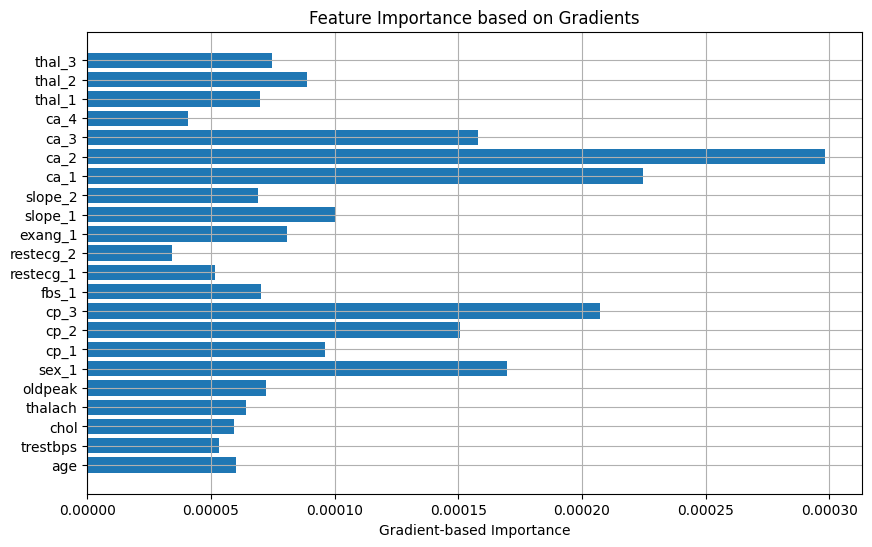

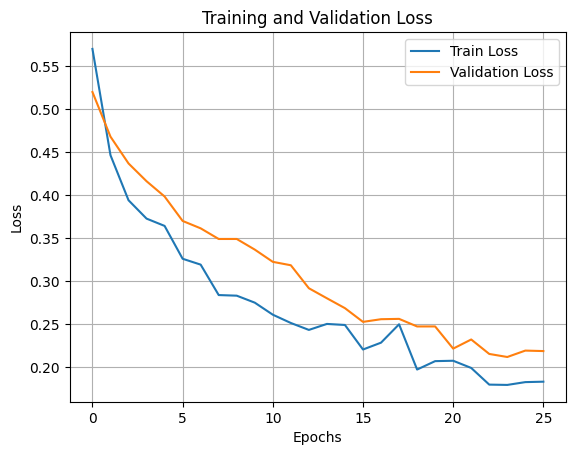

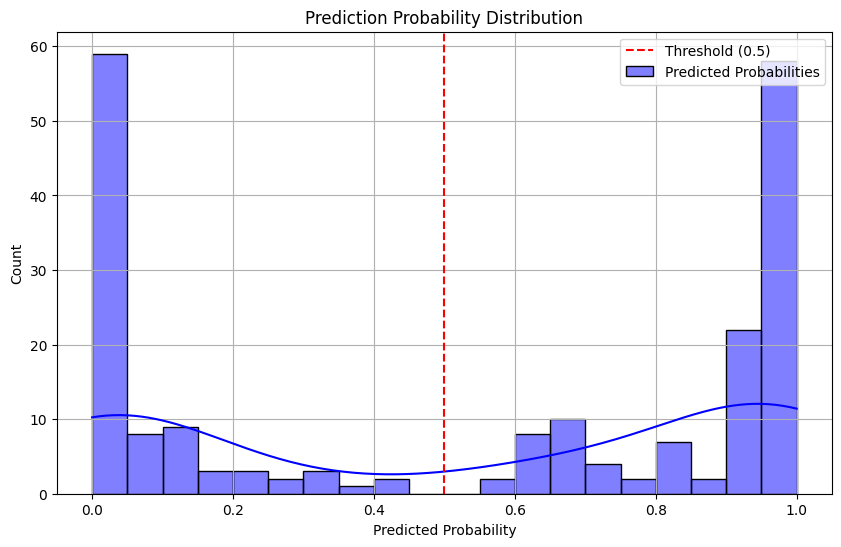

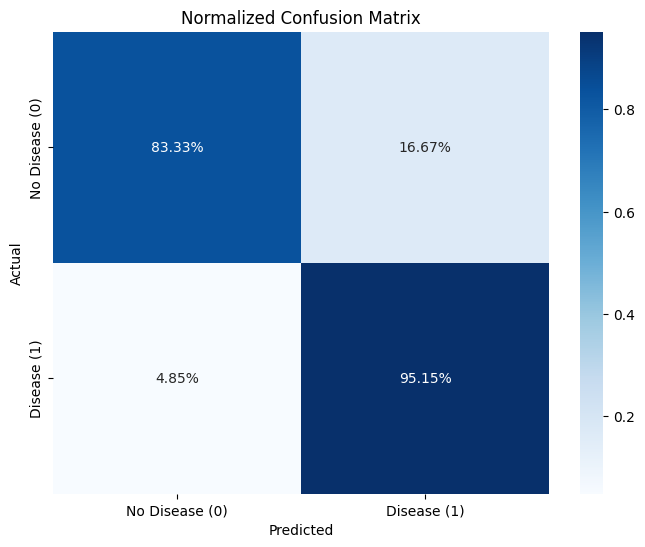

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve
from torch.utils.data import Dataset, DataLoader
from imblearn.over_sampling import SMOTE
import torch.optim.lr_scheduler as lr_scheduler
import shap


def preprocess_data(df):
    df = df.fillna(df.mean())


    numeric_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
    categorical_features = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']


    y = df['target'].values
    X = df.drop(columns=['target'])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
            ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), categorical_features)
        ])

    X = preprocessor.fit_transform(X)

    return X, y, preprocessor


class HeartDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class HeartNet(nn.Module):
    def __init__(self, input_size):
        super(HeartNet, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.fc(x)

class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_loss = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None or val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

def train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, epochs=50, device='cpu'):
    model.to(device)
    train_losses, val_losses = [], []
    early_stopping = EarlyStopping(patience=5, delta=0.01)

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            y_pred = model(X_batch).squeeze()
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                y_pred = model(X_batch).squeeze()
                val_loss += criterion(y_pred, y_batch).item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        scheduler.step(val_loss)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered.")
            break

    return train_losses, val_losses

def visualize_prediction_distribution(y_test, y_prob):
    plt.figure(figsize=(10, 6))
    sns.histplot(y_prob, bins=20, kde=True, color='blue', label='Predicted Probabilities')
    plt.axvline(0.5, color='red', linestyle='--', label='Threshold (0.5)')
    plt.title('Prediction Probability Distribution')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Count')
    plt.legend()
    plt.grid()
    plt.show()

def visualize_confusion_matrix(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    cm_normalized = cm / cm.sum(axis=1, keepdims=True)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues', xticklabels=['No Disease (0)', 'Disease (1)'],
                yticklabels=['No Disease (0)', 'Disease (1)'])
    plt.title('Normalized Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

def visualize_gradient_importance(grad_importance, feature_names, preprocessor):
    processed_feature_names = []

    for i, (name, transformer, features) in enumerate(preprocessor.transformers_):
        if name == 'num':
            processed_feature_names.extend(features)
        elif name == 'cat':
            cat_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(features)
            processed_feature_names.extend(cat_feature_names)

    plt.figure(figsize=(10, 6))
    plt.barh(processed_feature_names, grad_importance)
    plt.xlabel('Gradient-based Importance')
    plt.title('Feature Importance based on Gradients')
    plt.grid(True)
    plt.show()

def compute_gradient_based_importance(model, X, y, criterion):
    model.eval()
    X = torch.tensor(X, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.float32)

    X.requires_grad = True
    outputs = model(X).squeeze()

    loss = criterion(outputs, y)
    loss.backward()

    gradients = X.grad.abs().mean(dim=0).numpy()

    return gradients


def main():
    df = pd.read_csv('heart.csv')
    print(f"총 데이터 수: {df.shape[0]}")
    X, y, preprocessor = preprocess_data(df)
    feature_names = df.drop(columns=['target']).columns.tolist()

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    train_dataset = HeartDataset(X_train_resampled, y_train_resampled)
    test_dataset = HeartDataset(X_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = HeartNet(input_size=X_train.shape[1])
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

    train_losses, val_losses = train_model(model, criterion, optimizer, scheduler, train_loader, test_loader,
                                           epochs=50, device=device)

    grad_importance = compute_gradient_based_importance(model, X_train, y_train, criterion)

    visualize_gradient_importance(grad_importance, feature_names, preprocessor)

    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid()
    plt.show()

    y_prob = []
    y_pred = []
    with torch.no_grad():
        for X_batch, _ in test_loader:
            prob = model(X_batch).squeeze()
            pred = (prob > 0.5).float()
            y_prob.extend(prob.cpu().numpy())
            y_pred.extend(pred.cpu().numpy())

    visualize_prediction_distribution(y_test, y_prob)
    visualize_confusion_matrix(y_test, y_pred)



if __name__ == "__main__":
    main()
